UPDATE ON 2023/03/16

This file is designed for preparing FDDA data (http://vis-www.cs.umass.edu/fddb/). 
1. Transform the original annotation from ellipse bounding box to rectangular bounding box
2. Split raw data into training, validation and testing data
3. Crop faces for face classification
4. Crop non-faces for non-face classification

In [1]:
from prepare_data import *
from visualise import *
from train_model import *
import uuid
import json

In [2]:
'''
1. IS_SAVE_RAW_DATA = True helps gather all 10 folds of FDDB data into 1 folder
2. IS_SPLIT = True helps to split the raw data into training, validation and testing data
3. IS_GET_CROP_DATA = True helps to crop positive and negative face image into folders of training, validation and
testing data
4. IMG_DIR = the downloaded original FDDB image
5. LAB_DIR = the downloaded original labels
6. RAW_DIR = the directory to be saved when IS_SAVE_RAW_DATA is True
7. DATA_DIR = the directory to be saved when IS_GET_CROP_DATA is True
'''

IS_SAVE_RAW_DATA = False
IS_SPLIT = True
IS_GET_CROP_DATA = True

IMG_DIR = 'originalPics'
LAB_DIR = 'FDDB-folds'
RAW_DIR = 'raw'
DATA_DIR = 'data'
DATA_FOLDERS = ['train', 'valid', 'test']

In [3]:
#load data from FDDB raw data
all_data = get_FDDB_data_and_labels(IMG_DIR, LAB_DIR)

assert len(all_data) == 2845
assert sum(len(data['boxes']) for data in all_data) == 5171 - 1

In [4]:
ind = 99
print(all_data[ind]['boxes'])
print(all_data[ind]['data_path'])

[[12, 92, 97, 216], [64, 45, 150, 191], [203, 74, 308, 210], [166, -8, 259, 117]]
originalPics/2002/08/19/big/img_738


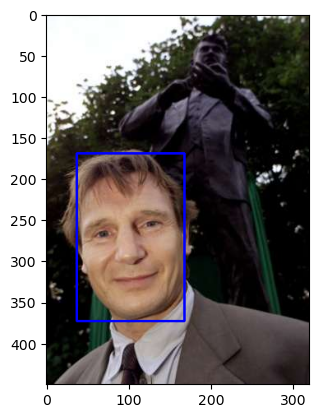

In [5]:
#visualise bounding boxes from RAW_DIR

ind = random.randint(0, len(all_data))
img = cv2.cvtColor(cv2.imread(all_data[ind]['data_path'] + '.jpg'), cv2.COLOR_BGR2RGB)

visualise_boxes(img, all_data[ind]['boxes'])
plt.imshow(img)
plt.show()

In [6]:
if IS_SAVE_RAW_DATA:
    for i in range(len(all_data)):
        uid = str(uuid.uuid1())
        img_load = all_data[i]['data_path'] + '.jpg'
        img_save = os.path.join(RAW_DIR, uid + '.jpg' )
        lab_save = os.path.join(RAW_DIR, uid + '.json')

        annotation = all_data[i].copy()
        annotation['data_path'] = img_save

        img = cv2.imread(img_load)
        cv2.imwrite(img_save, img)
        with open(lab_save, 'w') as f:
            json.dump(annotation, f)

In [7]:
if IS_SPLIT:
    uids      = gather_uid(RAW_DIR)
    uid_split = split_ids(uids, train = 0.8, valid = 0.1, test = 0.1)

    N = sum([len(_) for _ in uid_split if _ is not None])
    
    print('N:', N)
    print('train_N: ', len(uid_split[0]))
    print('valid_N: ', len(uid_split[1]))
    print('test_N: ' , len(uid_split[2]))
    assert len(uids) == 2845

N: 2845
train_N:  2276
valid_N:  284
test_N:  285


In [8]:
uid_chk = uid_split[0] + uid_split[1] + uid_split[2]

In [9]:
print(len(np.unique(uid_chk)))

2845


In [10]:
boxes_sum = [0, 0, 0]
for i, DATA_FOLDER in enumerate(DATA_FOLDERS):
    for j, uid in enumerate(uid_split[i]):
        #load image and label path
        lab_load = os.path.join(RAW_DIR, f'{uid}.json')
        lab = json.load(open(lab_load, 'r'))
        boxes = lab['boxes']
        boxes_sum[i] += len(boxes)

In [11]:
if IS_GET_CROP_DATA:
    N_face_train = N_nface_train = 0
    N_face_valid = N_nface_valid = 0
    N_face_test  = N_nface_test = 0
    dboxes_sum = [0, 0, 0]
    for i, DATA_FOLDER in enumerate(DATA_FOLDERS):
        for j, uid in enumerate(uid_split[i]):
            #load image and label path
            img_load = os.path.join(RAW_DIR, f'{uid}.jpg')
            lab_load = os.path.join(RAW_DIR, f'{uid}.json')

            pc_imgs, pc_labs, boxes_num = get_pos_crop_img(img_load, lab_load)
            nc_imgs, nc_labs = get_neg_crop_img(img_load, lab_load, max_neg_num = len(pc_imgs))
            
            dboxes_sum[i] += boxes_num
            
            for k in range(len(pc_imgs)):
                #save label and image
                img_save = os.path.join(DATA_DIR, DATA_FOLDER, 'face', f'{uid}-{k}.jpg')
                lab_save = os.path.join(DATA_DIR, DATA_FOLDER, 'face', f'{uid}-{k}.json')
                cv2.imwrite(img_save, pc_imgs[k])
                with open(lab_save, 'w') as f:
                    json.dump(pc_labs[k], f)
                   
            for k in range(len(nc_imgs)):
                #save label and image
                img_save = os.path.join(DATA_DIR, DATA_FOLDER, 'non_face', f'{uid}-{k}.jpg')
                lab_save = os.path.join(DATA_DIR, DATA_FOLDER, 'non_face', f'{uid}-{k}.json')
                cv2.imwrite(img_save, nc_imgs[k])
                with open(lab_save, 'w') as f:
                    json.dump(nc_labs[k], f)
                    
            if DATA_FOLDER == 'train':
                N_face_train += len(pc_imgs)
                N_nface_train += len(nc_imgs)
            elif DATA_FOLDER == 'valid':
                N_face_valid += len(pc_imgs)
                N_nface_valid += len(nc_imgs)
            elif DATA_FOLDER == 'test':
                N_face_test += len(pc_imgs)
                N_nface_test += len(nc_imgs)

In [12]:
assert dboxes_sum[0] == boxes_sum[0]
assert dboxes_sum[1] == boxes_sum[1]
assert dboxes_sum[2] == boxes_sum[2]
                                  
print('N_dboxes_train:', dboxes_sum[0], '\t N_boxes_train:', boxes_sum[0])
print('N_dboxes_valid:', dboxes_sum[1], '\t N_boxes_valid:', boxes_sum[1])
print('N_dboxes_test:' , dboxes_sum[2], '\t N_boxes_test:' , boxes_sum[2])

N_dboxes_train: 4134 	 N_boxes_train: 4134
N_dboxes_valid: 471 	 N_boxes_valid: 471
N_dboxes_test: 565 	 N_boxes_test: 565


In [13]:
print('N_face_train:', N_face_train)
print('N_face_valid:', N_face_valid)
print('N_face_test:', N_face_test)
print('N_nface_train:', N_nface_train)
print('N_nface_valid:', N_nface_valid)
print('N_nface_test:', N_nface_test)


N_face_train: 41212
N_face_valid: 4705
N_face_test: 5646
N_nface_train: 41212
N_nface_valid: 4705
N_nface_test: 5646


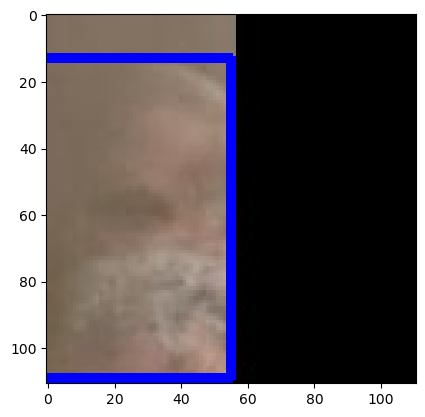

In [29]:
#visualise bounding boxes from training data

root = os.path.join('data','train','face')
path = os.listdir(root)
img_path = sorted([file for file in path if file.split('.')[-1] == 'jpg'])
lab_path = sorted([file for file in path if file.split('.')[-1] == 'json'])

ind = np.random.randint(0, len(img_path))

img_load = os.path.join(root, img_path[ind])
lab_load = os.path.join(root, lab_path[ind])
uid = '80f6c422-c90c-11ed-9720-a2d46b2f7ca3-40'
img_load = os.path.join(root, uid + '.jpg')
lab_load = os.path.join(root, uid + '.json')

img = cv2.cvtColor(cv2.imread(img_load), cv2.COLOR_BGR2RGB)
lab = json.load(open(lab_load, 'r'))

box = lab['box']
box[0] *= img.shape[1]
box[1] *= img.shape[0]
box[2] *= img.shape[1]
box[3] *= img.shape[0]

visualise_boxes(img, [box])
plt.imshow(img)
plt.show()